Este dataset representa variables de operacion de un espesador de relave de cobre, contiene los datos reales y los medidos para identificar fallas 
, patrones con el fin de optimizar la operacion

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [28]:
#load data
df = pd.read_parquet("data/processed/thickener_timeseries_deadband0p27_sp4.parquet")
df.head()

,timestamp,Qf_pulp_m3h,Qf_dilution_m3h,Qf_total_m3h,Qf_m3h,Solids_f_pct,Feedwell_Solids_pct,FeedDilution_On,FeedDilution_factor,PSD_fines_idx,...,ActionScore_turb,ActionScore_torque,WaterRecovery_proxy,spec_limit_NTU,event_limit_NTU,event_now,event_type_raw,event_type,Regime,target_event_30m
0,2026-01-01 00:00:00,599.873690,0.0,599.873690,599.873690,30.662771,30.415933,0,1.0,0.137223,...,0.0,0.0,0.230845,200.0,100.0,0,NONE,NONE,NORMAL,0
1,2026-01-01 00:05:00,550.283167,0.0,550.283167,550.283167,31.125261,31.108630,0,1.0,0.127340,...,0.0,0.0,0.338559,200.0,100.0,0,NONE,NONE,NORMAL,0
2,2026-01-01 00:10:00,558.605725,0.0,558.605725,558.605725,29.347387,29.934241,0,1.0,0.123208,...,0.0,0.0,0.264355,200.0,100.0,0,NONE,NONE,NORMAL,0
3,2026-01-01 00:15:00,600.626605,0.0,600.626605,600.626605,32.246723,32.142964,0,1.0,0.119377,...,0.0,0.0,0.393193,200.0,100.0,0,NONE,NONE,NORMAL,0
4,2026-01-01 00:20:00,606.473918,0.0,606.473918,606.473918,32.598267,32.101219,0,1.0,0.113533,...,0.0,0.0,0.342130,200.0,100.0,0,NONE,NONE,NORMAL,0


In [ ]:
# timestamp como index
df.index
# en una serie de tiempo el index debe ser del tipo datetime no un rango

In [3]:
# primero nos sercioramos que no hayan dupolicados en la columna que sera el index
df["timestamp"].is_unique

True

In [4]:
# ahora lo convertimos a datetime y lo seteamos como index
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.set_index('timestamp',inplace=True)
df.info()


<class 'pandas.DataFrame'>
DatetimeIndex: 25920 entries, 2026-01-01 00:00:00 to 2026-03-31 23:55:00
Data columns (total 42 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Qf_pulp_m3h              25920 non-null  float64
 1   Qf_dilution_m3h          25920 non-null  float64
 2   Qf_total_m3h             25920 non-null  float64
 3   Qf_m3h                   25661 non-null  float64
 4   Solids_f_pct             25920 non-null  float64
 5   Feedwell_Solids_pct      25920 non-null  float64
 6   FeedDilution_On          25920 non-null  int64  
 7   FeedDilution_factor      25920 non-null  float64
 8   PSD_fines_idx            25920 non-null  float64
 9   Clay_pct                 25920 non-null  float64
 10  Clay_idx                 25920 non-null  float64
 11  Floc_gpt                 25920 non-null  float64
 12  FlocActivity_factor      25920 non-null  float64
 13  FlocEffective_gpt        25920 non-null  float64
 14

In [5]:
# datos faltantes
df.isna().sum()

Qf_pulp_m3h                  0
Qf_dilution_m3h              0
Qf_total_m3h                 0
Qf_m3h                     259
Solids_f_pct                 0
Feedwell_Solids_pct          0
FeedDilution_On              0
FeedDilution_factor          0
PSD_fines_idx                0
Clay_pct                     0
Clay_idx                     0
Floc_gpt                     0
FlocActivity_factor          0
FlocEffective_gpt            0
FlocPrepFail_On              0
UF_capacity_factor           0
Qu_base_m3h                  0
Qu_sp_delta_m3h              0
Qu_m3h                       0
Floc_sp_delta_gpt            0
Solids_u_pct               259
BedLevel_m                   0
UF_YieldStress_Pa            0
Bogging_factor               0
RakeTorque_kNm               0
RakeTorque_pct               0
Overflow_Turb_NTU_clean      0
Overflow_Turb_NTU          259
ControlMode                  0
OperatorAction               0
RecommendedAction            0
ExpectedTradeoff             0
ActionSc

se puede observar que faltan entradas en la columna de % de solido del underflow medido, turbiedad medida, y flujo de alimentacion medido, el numero de entradas faltantes coincide, pero hay que confirmar si las 3 fallaron al mismo tiempo o en periodos diferentes

In [6]:
# Buscar las entradas faltantes y comparar el index para ver si hay coincidencia
cols = ['Solids_u_pct', 'Overflow_Turb_NTU','Qf_m3h']

# dataframe booleano
dfbool = df[cols].isna()
dfboolint = dfbool.astype(int) 

# verificacion de coorelacion
dfboolint.corr()


,Solids_u_pct,Overflow_Turb_NTU,Qf_m3h
Solids_u_pct,1.000000,-0.002293,0.005507
Overflow_Turb_NTU,-0.002293,1.000000,-0.002293
Qf_m3h,0.005507,-0.002293,1.000000


hay ciertas coincidencias pero por lo visto no estan coorelacionadas

In [7]:
# cuantas veces estan juntas?

dfboolint.groupby(cols).size()

Solids_u_pct  Overflow_Turb_NTU  Qf_m3h
0             0                  0         25151
                                 1           253
              1                  0           255
                                 1             2
1             0                  0           253
                                 1             4
              1                  0             2
dtype: int64

Resumen

* No parece falla de PLC
* No parece falla de comunicación global
* Parecen sensores independientes
* Las co-ocurrencias dobles son probablemente coincidencia estadística


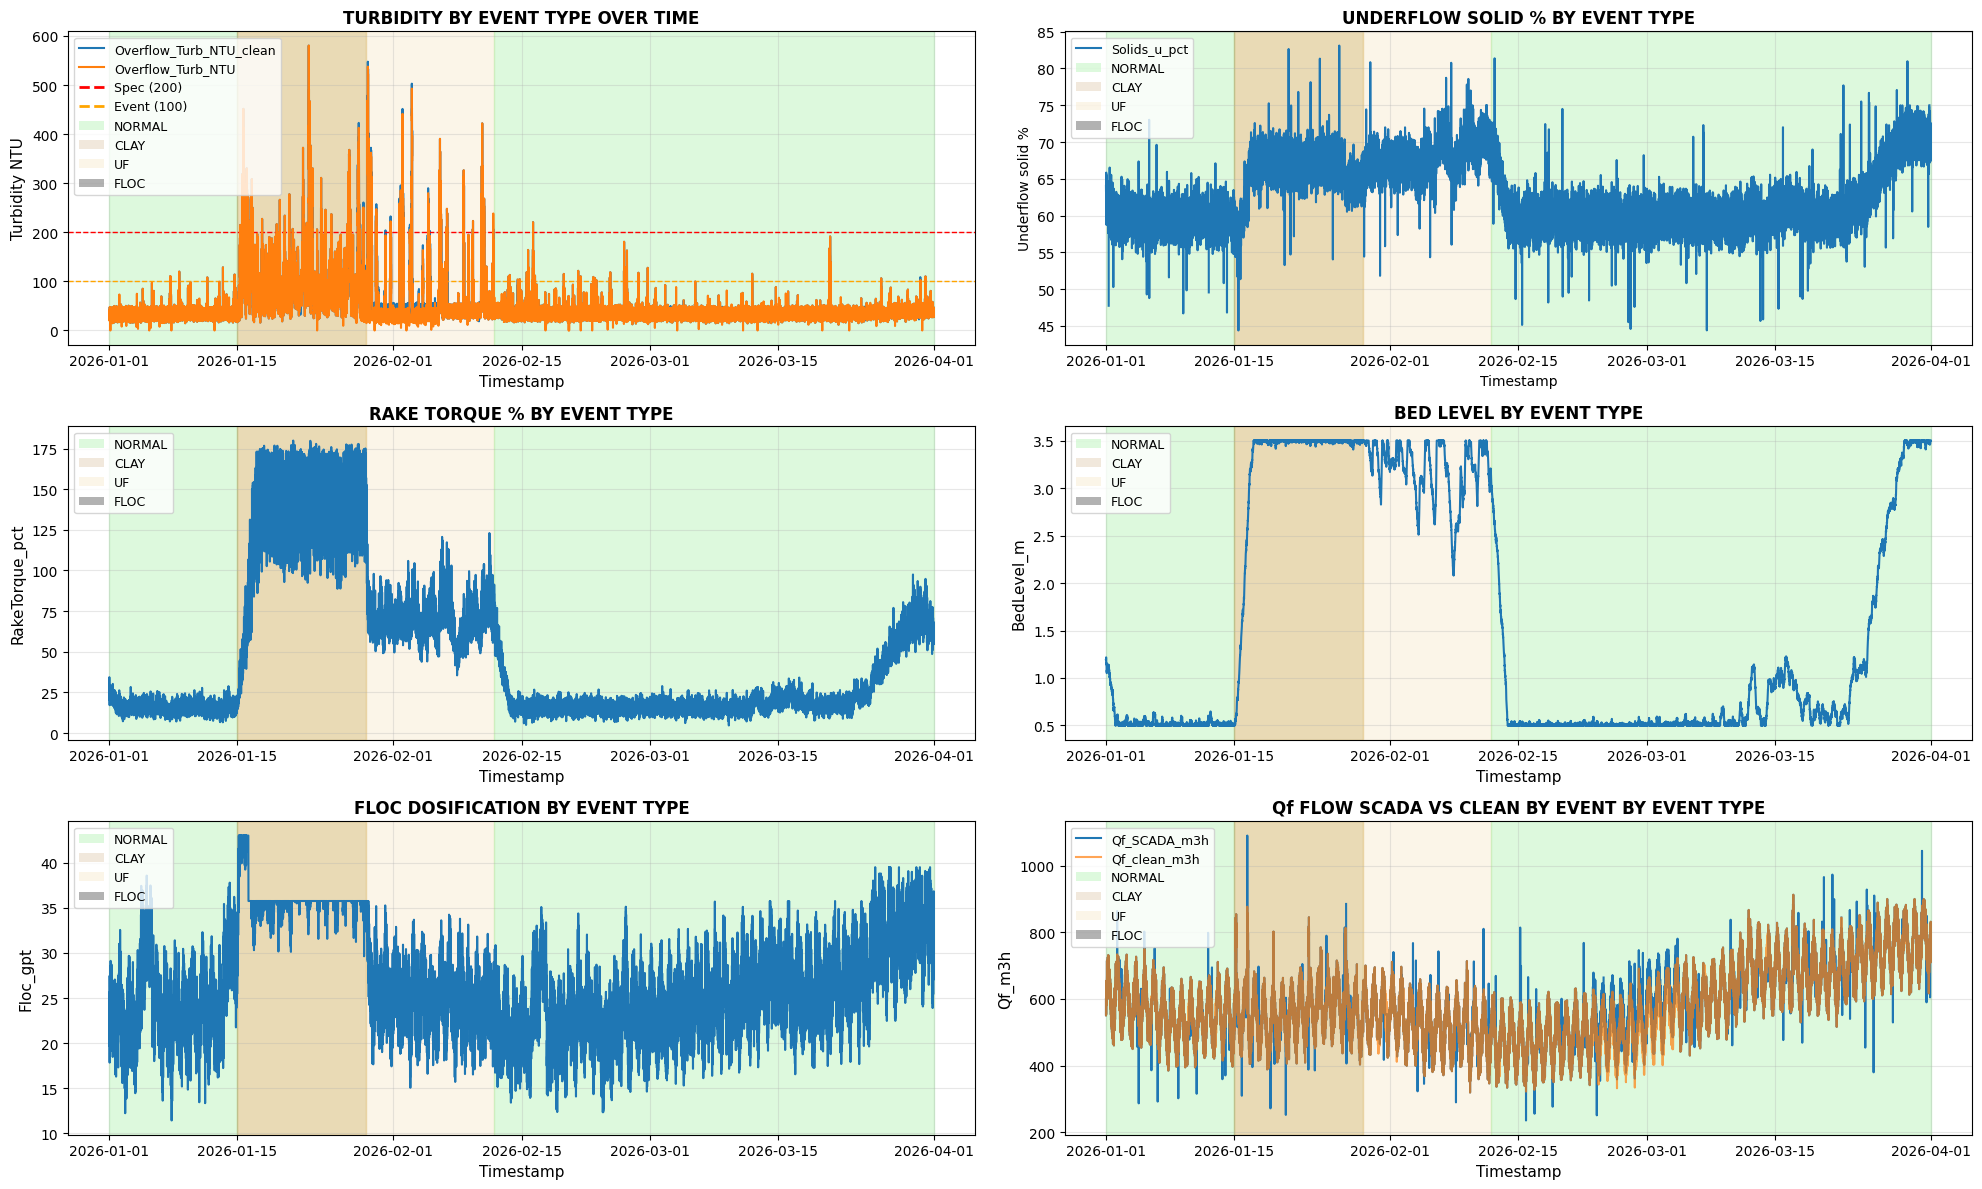

In [128]:
fig,ax = plt.subplots(3,2,figsize=(20,12))

colors = {
    'NORMAL':'lightgreen',
    'CLAY':'darkgoldenrod',
    'UF':'wheat',
    'FLOC':'k'
}
df['regime_group'] = (df['Regime'] != df['Regime'].shift()).cumsum() # crea una nueva columna de identificacion para diferenciar los cambios de regime

# funcion para colorer cada grupo

# CHART 1 TURBIDITY BY EVENT TYPE OVER TIME ==============
for group_id, group_df in df.groupby('regime_group'):

    # seleccionar el extracto del df para el regime correspondiente para procesarlo
    regime = group_df['Regime'].iloc[0] #toma el primer valor de la columna Regime de ese extracto del df
    #tomar el valor para el inicio y fin del regime
    start = group_df['timestamp'].iloc[0] # toma el primer valor de la columna timestamp
    end = group_df['timestamp'].iloc[-1] # toma el ultimo valor de la columna timestamp
    color =  colors.get(regime, 'gray')
    #pintar el fondo con los parametros extraidos
    ax[0,0].axvspan(start, end, alpha=0.3, color=color, zorder=1)

otl1 = ax[0,0].plot(df['timestamp'],df["Overflow_Turb_NTU_clean"], label='Overflow_Turb_NTU_clean',zorder=2)
otl2 = ax[0,0].plot(df['timestamp'],df["Overflow_Turb_NTU"], label='Overflow_Turb_NTU',zorder=3)
ax[0,0].set_xlabel("Timestamp", fontsize=11)
ax[0,0].set_ylabel("Turbidity NTU", fontsize=11)
ax[0,0].set_title("TURBIDITY BY EVENT TYPE OVER TIME", fontsize=12, fontweight='bold')
ax[0,0].axhline(y=df["spec_limit_NTU"].iloc[0], color='red', linestyle='--', linewidth=1, label='spec limit (200 NTU)',zorder=2)
ax[0,0].axhline(y=df["event_limit_NTU"].iloc[0], color='orange', linestyle='--', linewidth=1, label='event limit (100 NTU)', zorder=2)

legend_elements = [
    plt.Line2D([0], [0], color='red', linestyle='--', linewidth=2, label='Spec (200)'),
    plt.Line2D([0], [0], color='orange', linestyle='--', linewidth=2, label='Event (100)'),
    Patch(facecolor='lightgreen', alpha=0.3, label='NORMAL'),
    Patch(facecolor='tan', alpha=0.3, label='CLAY'),
    Patch(facecolor='wheat', alpha=0.3, label='UF'),
    Patch(facecolor='k', alpha=0.3, label='FLOC')
]
ax[0,0].legend(handles=otl1 + otl2 + legend_elements, loc='upper left', fontsize=9)
ax[0,0].grid(True, alpha=0.3)
ax[0,0].tick_params(axis='x')

# CHART 2 ============ UNDERFLOW SOLID % BY EVENT TYPE =========================
line1 = ax[0,1].plot(df['timestamp'],df["Solids_u_pct"], label='Solids_u_pct')
ax[0,1].set_xlabel("Timestamp")
ax[0,1].set_ylabel("Underflow solid %")
ax[0,1].set_title("UNDERFLOW SOLID % BY EVENT TYPE",fontsize=12, fontweight='bold')
for group_id, group_df in df.groupby('regime_group'):

    # seleccionar el extracto del df para el regime correspondiente para procesarlo
    regime = group_df['Regime'].iloc[0] #toma el primer valor de la columna Regime de ese extracto del df
    #tomar el valor para el inicio y fin del regime
    start = group_df['timestamp'].iloc[0] # toma el primer valor de la columna timestamp
    end = group_df['timestamp'].iloc[-1] # toma el ultimo valor de la columna timestamp
    color =  colors.get(regime, 'gray')
    #pintar el fondo con los parametros extraidos
    ax[0,1].axvspan(start, end, alpha=0.3, color=color, zorder=1)
legend_elements = [
    Patch(facecolor='lightgreen', alpha=0.3, label='NORMAL'),
    Patch(facecolor='tan', alpha=0.3, label='CLAY'),
    Patch(facecolor='wheat', alpha=0.3, label='UF'),
    Patch(facecolor='k', alpha=0.3, label='FLOC')
]
ax[0,1].legend(handles= line1 + legend_elements, loc='upper left', fontsize=9)
ax[0,1].grid(True, alpha=0.3)
ax[0,1].tick_params(axis='x')

# CHART 3 ================= RAKE TORQUE % BY EVENT TYPE ==========================

for group_id, group_df in df.groupby('regime_group'):

    # seleccionar el extracto del df para el regime correspondiente para procesarlo
    regime = group_df['Regime'].iloc[0] #toma el primer valor de la columna Regime de ese extracto del df
    #tomar el valor para el inicio y fin del regime
    start = group_df['timestamp'].iloc[0] # toma el primer valor de la columna timestamp
    end = group_df['timestamp'].iloc[-1] # toma el ultimo valor de la columna timestamp
    color =  colors.get(regime, 'gray')
    #pintar el fondo con los parametros extraidos
    ax[1,0].axvspan(start, end, alpha=0.3, color=color, zorder=1)

ax[1,0].plot(df['timestamp'],df["RakeTorque_pct"], label='RakeTorque_pct',zorder=3)
ax[1,0].set_xlabel("Timestamp", fontsize=11)
ax[1,0].set_ylabel("RakeTorque_pct", fontsize=11)
ax[1,0].set_title("RAKE TORQUE % BY EVENT TYPE", fontsize=12, fontweight='bold')

legend_elements = [
    Patch(facecolor='lightgreen', alpha=0.3, label='NORMAL'),
    Patch(facecolor='tan', alpha=0.3, label='CLAY'),
    Patch(facecolor='wheat', alpha=0.3, label='UF'),
    Patch(facecolor='k', alpha=0.3, label='FLOC')
]
ax[1,0].legend(handles=legend_elements, loc='upper left', fontsize=9)
ax[1,0].grid(True, alpha=0.3)
ax[1,0].tick_params(axis='x')

# CHART 4 =========== BED LEVEL BY EVENT TYPE =========================

for group_id, group_df in df.groupby('regime_group'):

    # seleccionar el extracto del df para el regime correspondiente para procesarlo
    regime = group_df['Regime'].iloc[0] #toma el primer valor de la columna Regime de ese extracto del df
    #tomar el valor para el inicio y fin del regime
    start = group_df['timestamp'].iloc[0] # toma el primer valor de la columna timestamp
    end = group_df['timestamp'].iloc[-1] # toma el ultimo valor de la columna timestamp
    color =  colors.get(regime, 'gray')
    #pintar el fondo con los parametros extraidos
    ax[1,1].axvspan(start, end, alpha=0.3, color=color, zorder=1)

ax[1,1].plot(df['timestamp'],df["BedLevel_m"], label='BedLevel_m',zorder=3)
ax[1,1].set_xlabel("Timestamp", fontsize=11)
ax[1,1].set_ylabel("BedLevel_m", fontsize=11)
ax[1,1].set_title("BED LEVEL BY EVENT TYPE", fontsize=12, fontweight='bold')

legend_elements = [
    Patch(facecolor='lightgreen', alpha=0.3, label='NORMAL'),
    Patch(facecolor='tan', alpha=0.3, label='CLAY'),
    Patch(facecolor='wheat', alpha=0.3, label='UF'),
    Patch(facecolor='k', alpha=0.3, label='FLOC')
]
ax[1,1].legend(handles=legend_elements, loc='upper left', fontsize=9)
ax[1,1].grid(True, alpha=0.3)
ax[1,1].tick_params(axis='x')

# CHART 5 =============== FLOC DOSIFICATION BY EVENT ====================

for group_id, group_df in df.groupby('regime_group'):

    # seleccionar el extracto del df para el regime correspondiente para procesarlo
    regime = group_df['Regime'].iloc[0] #toma el primer valor de la columna Regime de ese extracto del df
    #tomar el valor para el inicio y fin del regime
    start = group_df['timestamp'].iloc[0] # toma el primer valor de la columna timestamp
    end = group_df['timestamp'].iloc[-1] # toma el ultimo valor de la columna timestamp
    color =  colors.get(regime, 'gray')
    #pintar el fondo con los parametros extraidos
    ax[2,0].axvspan(start, end, alpha=0.3, color=color, zorder=1)

ax[2,0].plot(df['timestamp'],df["Floc_gpt"], label='Floc_gpt',zorder=3)
ax[2,0].set_xlabel("Timestamp", fontsize=11)
ax[2,0].set_ylabel("Floc_gpt", fontsize=11)
ax[2,0].set_title("FLOC DOSIFICATION BY EVENT TYPE", fontsize=12, fontweight='bold')

legend_elements = [
    Patch(facecolor='lightgreen', alpha=0.3, label='NORMAL'),
    Patch(facecolor='tan', alpha=0.3, label='CLAY'),
    Patch(facecolor='wheat', alpha=0.3, label='UF'),
    Patch(facecolor='k', alpha=0.3, label='FLOC')
]
ax[2,0].legend(handles=legend_elements, loc='upper left', fontsize=9)
ax[2,0].grid(True, alpha=0.3)
ax[2,0].tick_params(axis='x')


# CHART 6 =============== Qf FLOW SCADA VS CLEAN BY EVENT ====================

for group_id, group_df in df.groupby('regime_group'):

    # seleccionar el extracto del df para el regime correspondiente para procesarlo
    regime = group_df['Regime'].iloc[0] #toma el primer valor de la columna Regime de ese extracto del df
    #tomar el valor para el inicio y fin del regime
    start = group_df['timestamp'].iloc[0] # toma el primer valor de la columna timestamp
    end = group_df['timestamp'].iloc[-1] # toma el ultimo valor de la columna timestamp
    color =  colors.get(regime, 'gray')
    #pintar el fondo con los parametros extraidos
    ax[2,1].axvspan(start, end, alpha=0.3, color=color, zorder=1)

LINE1 = ax[2,1].plot(df['timestamp'],df["Qf_m3h"], label='Qf_SCADA_m3h',zorder=3)
LINE2 = ax[2,1].plot(df['timestamp'],df["Qf_total_m3h"], alpha = 0.7, label='Qf_clean_m3h',zorder=3)
ax[2,1].set_xlabel("Timestamp", fontsize=11)
ax[2,1].set_ylabel("Qf_m3h", fontsize=11)
ax[2,1].set_title("Qf FLOW SCADA VS CLEAN BY EVENT BY EVENT TYPE", fontsize=12, fontweight='bold')

legend_elements = [
    Patch(facecolor='lightgreen', alpha=0.3, label='NORMAL'),
    Patch(facecolor='tan', alpha=0.3, label='CLAY'),
    Patch(facecolor='wheat', alpha=0.3, label='UF'),
    Patch(facecolor='k', alpha=0.3, label='FLOC')
]
ax[2,1].legend(handles= LINE1 + LINE2 + legend_elements, loc='upper left', fontsize=9)
ax[2,1].grid(True, alpha=0.3)
ax[2,1].tick_params(axis='x')


plt.tight_layout()  # Ajusta automáticamente los espacios
plt.show()

In [ ]:
# comparacion entre datos reales y medidos

df_temp = df[["timestamp","Overflow_Turb_NTU_clean","Overflow_Turb_NTU"]].melt(
    id_vars="timestamp"
    ,var_name = "Type"
    ,value_name= "Turbidity_NTU"
)


plt.figure(figsize=(18,6))
sns.set_context("notebook", font_scale=1.5)
sns.set_style("whitegrid")
sns.lineplot(
    data=df_temp
    ,x="timestamp"
    ,y="Turbidity_NTU"
    ,hue="Type"
    ,legend= ["Medida","Real"]
    ,color=["blue","orange"]
    ,errorbar=None    
    ,linewidth=1
    ,alpha=0.5
)

plt.title("Comparación entre datos medidos y reales")
plt.xlabel("Fecha")
plt.ylabel("Turbidez (NTU)")
plt.legend(title="Tipo de Medición", labels=["Medida","Real"])


KeyError: "['timestamp'] not in index"

se observa que no hay 